# Pokemon Generation using GANs [WGAN]

## Imports

In [0]:
from __future__ import print_function
#%matplotlib inline
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from matplotlib import animation
from IPython.display import HTML
from torchsummary import summary

## Connect to drive

In order to use pokemon data you need to get data from [this Github project](https://github.com/DonaCrio/Pokemon-dataset).\
Then you need to convert them to `.png` and save them in a file nammed `data` in your Google Drive.\
**Do not forget to change the `prefix` variable to the path to your data.**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
prefix = "gdrive/My Drive/ECP/DL"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Parameters input

In [3]:
# Set the seed manually or randomly

seed = 500 # Use 'random.randint(1, 10000)' to deactivate reproductability
print("seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

seed:  500


In [0]:
# Size of z latent vector# Root directory of the dataset
PATH_DATA = os.path.join(prefix, "data")
PATH_NOTEBOOK = os.path.join(prefix, "GAN_WASSERSTEIN")
# Number of channels per image
IMG_N_CHANNELS = 3 #@param {type: "integer", default: 3}
# Rescale size before random crop
IMG_RESCALE_SIZE = 150 #@param {type: "integer", default: 180}
# Final size of the image
IMG_SIZE = 128 #@param {type: "integer", default: 128}
# Number of workers for dataloader
N_WORKERS =  2 #@param {type: "integer", default: 2}

# Size of the latent vector
LATENT_VECTOR_SIZE =  64 #@param {type:'integer', default: 64}
# Size of the base feature map in generator
G_FEATURE_SIZE = 32 #@param {type:'integer', default: 64}
# Size of the base feature map in discriminator
D_FEATURE_SIZE =  32 #@param {type:'integer', default: 64}

# Batch size during training
BATCH_SIZE = 128 #@param {type:'integer', default: 64}
# Number of training epochs
NUM_EPOCHS = 2000 #@param {type:'integer', default: 300}
# Learning rate for optimizers
LEARNING_RATE = 0.0001  #@param {type:'number', default: 0.00005}
# Number of training iterations for the discriminator befor training the generator
D_N_TRAIN =  1# @param {type:'integer', default:5}
# Adam optimizer parameters
BETA1 = 0.5 #@param {type: 'number', default: 0.5}
BETA2 = 0.999 #@param {type: 'number', default: 0.999}

## Data preparation

In [0]:
# We use a `torch.utils.data.DataLoader` to handle the data. That way we can easily apply random transformation to each batch at every epoch.

# Create the dataset
dataset = datasets.ImageFolder(root=PATH_DATA,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_RESCALE_SIZE),
                               transforms.RandomCrop(IMG_SIZE),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10, fill=(255, 255, 255)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=N_WORKERS)


In [6]:
# Uses the Colab GPU as a device if available

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


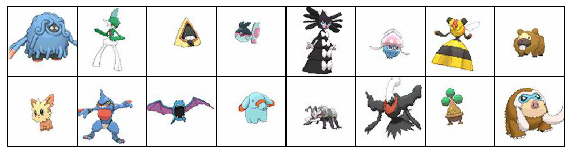

In [7]:
# Plots a sample of the processed data used for the training.

real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig(os.path.join(prefix, "test.jpg"))

## Models definition

In [0]:
# custom weights initialization called on generator and discriminator

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [0]:
# Generator definition

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    #def conv_block(in_features, out_features, normalize=True):
      #layers = [nn.ConvTranspose2d(in_features, out_features, 3, 2, 1, 1, bias=False)]
      #if normalize:
        #layers.append(nn.BatchNorm2d(out_features, 0.8))
      #layers.append(nn.LeakyReLU(0.2, inplace=True))
      #return layers

    #self.conv_blocks = nn.Sequential(
        #*conv_block(G_FEATURE_SIZE * 4, G_FEATURE_SIZE * 4),
        #*conv_block(G_FEATURE_SIZE * 4, G_FEATURE_SIZE * 2),
        #*conv_block(G_FEATURE_SIZE * 2 , G_FEATURE_SIZE * 2),
        #*conv_block(G_FEATURE_SIZE * 2 , G_FEATURE_SIZE),
    #)

    #self.input_bis = nn.Sequential(
        #nn.Linear(LATENT_VECTOR_SIZE, G_FEATURE_SIZE * 4 * 4, bias=False),
        #nn.BatchNorm1d(G_FEATURE_SIZE * 4 * 4),
        #nn.LeakyReLU(0.2, inplace=True)
    #)

    #self.output = nn.Sequential(
        #nn.ConvTranspose2d(G_FEATURE_SIZE, 3, 3, 2, 1, 1, bias=False),
        #nn.Tanh()
    #)

    def conv_block(in_features, out_features, kernel_size, stride, padding, out_padding, dropout=False):
      layers = [nn.ConvTranspose2d(in_features, out_features, kernel_size, stride, padding, out_padding, bias=False)]
      layers.append(nn.BatchNorm2d(out_features))
      layers.append(nn.ReLU(inplace=True))
      if dropout:
        layers.append(nn.Dropout(0.33))
      return layers

    self.conv_blocks = nn.Sequential(
        *conv_block(G_FEATURE_SIZE * 8, G_FEATURE_SIZE * 16, 5, 1, 2, 0, dropout=True),
        *conv_block(G_FEATURE_SIZE * 16, G_FEATURE_SIZE * 8, 5, 2, 2, 1, dropout=True),
        *conv_block(G_FEATURE_SIZE * 8 , G_FEATURE_SIZE * 4, 5, 2, 2, 1),
        *conv_block(G_FEATURE_SIZE * 4 , G_FEATURE_SIZE * 2, 5, 2, 2, 1),
        *conv_block(G_FEATURE_SIZE * 2 , G_FEATURE_SIZE, 5, 2, 2, 1)
    )

    self.input = nn.Sequential(
        nn.Linear(LATENT_VECTOR_SIZE, G_FEATURE_SIZE * 8 * 4 * 4),
        nn.BatchNorm1d(G_FEATURE_SIZE * 8 * 4 * 4)
    )

    self.output = nn.Sequential(
        nn.ConvTranspose2d(G_FEATURE_SIZE, IMG_N_CHANNELS, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, z):
    z = z.view(-1, LATENT_VECTOR_SIZE)
    x = self.input(z)
    x = x.view(-1, G_FEATURE_SIZE * 8, 4, 4)
    x = self.conv_blocks(x)
    img = self.output(x)
    return img

In [0]:
# Discriminator definition

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def conv_block(in_features, out_features):
      layers = [nn.Conv2d(in_features, out_features, 4, 2, 1, bias=False)]
      layers.append(nn.BatchNorm2d(out_features))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      return layers

    self.input = nn.Sequential(
        nn.Conv2d(IMG_N_CHANNELS, D_FEATURE_SIZE, 6, 4, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True)
    )
    
    self.convs = nn.Sequential(
        *conv_block(D_FEATURE_SIZE, D_FEATURE_SIZE * 2),
        *conv_block(D_FEATURE_SIZE * 2, D_FEATURE_SIZE * 2),
        *conv_block(D_FEATURE_SIZE * 2, D_FEATURE_SIZE * 2)
    )
    self.output = nn.Sequential(
        nn.Conv2d(D_FEATURE_SIZE * 2, 1, 4, 1, 0, bias=False)
    )

  def forward(self, img):
    x = self.input(img)
    x = self.convs(x)
    result = self.output(x)
    result = result.view(-1, 1)
    return result
    

## Training

In [21]:
# Creates the generator and the discriminator

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)

summary(generator, (LATENT_VECTOR_SIZE, 1, 1))
summary(discriminator, (IMG_N_CHANNELS, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]         266,240
       BatchNorm1d-2                 [-1, 4096]           8,192
   ConvTranspose2d-3            [-1, 512, 4, 4]       3,276,800
       BatchNorm2d-4            [-1, 512, 4, 4]           1,024
              ReLU-5            [-1, 512, 4, 4]               0
           Dropout-6            [-1, 512, 4, 4]               0
   ConvTranspose2d-7            [-1, 256, 8, 8]       3,276,800
       BatchNorm2d-8            [-1, 256, 8, 8]             512
              ReLU-9            [-1, 256, 8, 8]               0
          Dropout-10            [-1, 256, 8, 8]               0
  ConvTranspose2d-11          [-1, 128, 16, 16]         819,200
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
  ConvTranspose2d-14           [-1, 64,

In [0]:
# Creates the optimizers

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

In [0]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.randn(real_samples.size(0), 1, 1, 1, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.full((real_samples.shape[0], 1), 1.0, device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
# Training Loop

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, LATENT_VECTOR_SIZE, 1, 1, device=device)
img_list = []
G_losses = []
D_losses = []
D_x = []
D_G_z = []
batches_done = 0

print("Starting Training Loop...")

# For each epoch
for epoch in range(NUM_EPOCHS):

  for i, (imgs, _) in enumerate(dataloader, 0):

    # Configure input
    real_imgs = imgs.to(device)
    b_size = real_imgs.size(0)
    # ---------------------
    #  Train Discriminator
    # ---------------------

    optimizer_D.zero_grad()

    # Sample noise as generator input
    z = torch.randn(b_size, LATENT_VECTOR_SIZE, 1, 1, device=device)

    # Generate a batch of images
    fake_imgs = generator(z)

    real_validity = discriminator(real_imgs)
    fake_validity = discriminator(fake_imgs)

    D_x.append(real_validity.mean().item())
    D_G_z.append(fake_validity.mean().item())

    # compute graient penalty
    gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
    # Adversarial loss
    loss_D = -torch.mean(real_validity) + torch.mean(fake_validity) + 10 * gradient_penalty
    loss_D.backward()
    optimizer_D.step()

    optimizer_G.zero_grad()

    # Train the generator every n_critic iterations
    if i % D_N_TRAIN == 0:
      # -----------------
      #  Train Generator
      # -----------------

      
      # Generate a batch of images
      gen_imgs = generator(z)
      # Adversarial loss
      loss_G = -torch.mean(discriminator(gen_imgs))

      loss_G.backward()
      optimizer_G.step()

      D_losses.append(loss_D.item())
      G_losses.append(loss_G.item())
      print(
        "[Epoch %d/%d][Batch %d/%d][D loss: %f] [G loss: %f]"
        % (epoch, NUM_EPOCHS, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
      )   
      batches_done += D_N_TRAIN

  # Check how the generator is doing by saving G's output on fixed_noise
  if (epoch % (NUM_EPOCHS / 20) == 0) or ((epoch == NUM_EPOCHS - 1) and (i == len(dataloader) - 1)):
    with torch.no_grad():
      fake = generator(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

Streaming output truncated to the last 5000 lines.
[Epoch 1285/2000][Batch 6/7][D loss: 1.146297] [G loss: -7.393695]
[Epoch 1286/2000][Batch 0/7][D loss: -5.083447] [G loss: -4.211428]
[Epoch 1286/2000][Batch 1/7][D loss: -4.907588] [G loss: -2.816118]
[Epoch 1286/2000][Batch 2/7][D loss: -3.834803] [G loss: -2.662068]
[Epoch 1286/2000][Batch 3/7][D loss: -2.733891] [G loss: -5.440782]
[Epoch 1286/2000][Batch 4/7][D loss: -2.522323] [G loss: -4.306897]
[Epoch 1286/2000][Batch 5/7][D loss: -4.261344] [G loss: -1.204371]
[Epoch 1286/2000][Batch 6/7][D loss: -0.264424] [G loss: 1.864726]
[Epoch 1287/2000][Batch 0/7][D loss: -1.164618] [G loss: 5.704910]
[Epoch 1287/2000][Batch 1/7][D loss: -3.528211] [G loss: 7.565131]
[Epoch 1287/2000][Batch 2/7][D loss: -2.404065] [G loss: 4.857635]
[Epoch 1287/2000][Batch 3/7][D loss: -4.036120] [G loss: 7.935183]
[Epoch 1287/2000][Batch 4/7][D loss: -0.571424] [G loss: 7.677972]
[Epoch 1287/2000][Batch 5/7][D loss: -0.420088] [G loss: 6.378479]
[Epoc

## Results

In [0]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss during Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
plt.figure(figsize=(10,5))
plt.title("Discriminator results during training")
plt.plot(D_x,label="D(x)")
plt.plot(D_G_z,label="D(G(z))")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [0]:
# Animation to visualize steps on the fixed noise

#%%capture
fig = plt.figure(figsize=(15,15))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Animation size has reached 22822355 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


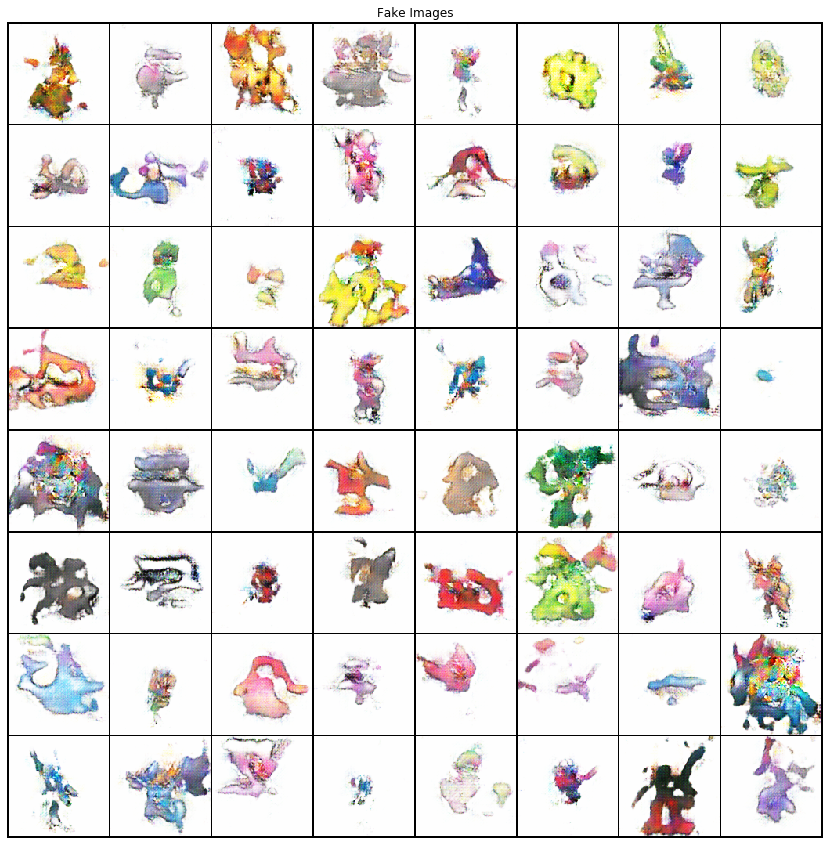

In [19]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the fake images from the last epoch
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [0]:
#%%capture
#fig = plt.figure(figsize=(15,15))
#plt.axis("off")
#ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
#ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

#HTML(ani.to_jshtml())

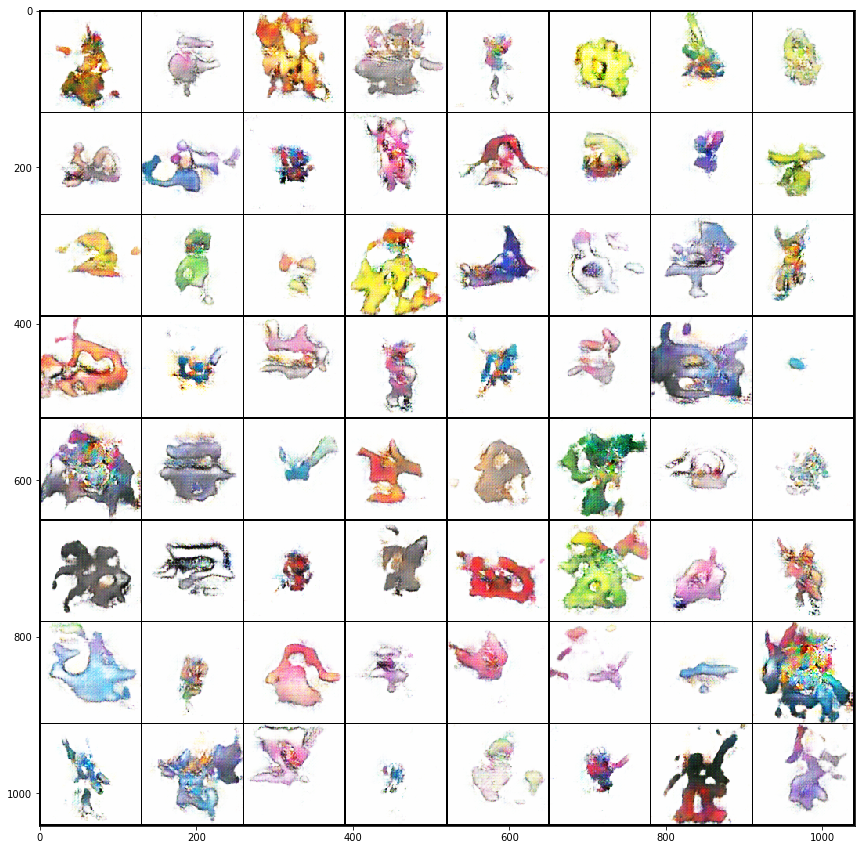

In [17]:
# Save images
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

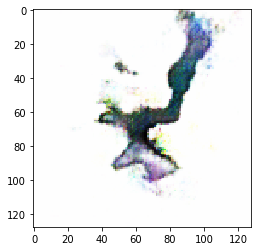

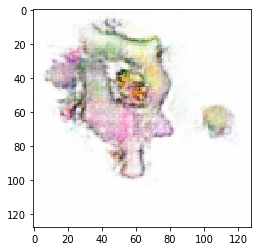

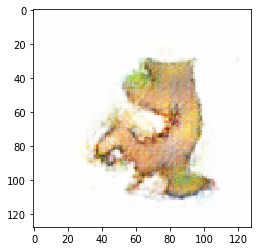

In [18]:
# Generate random pokemons
num_pokemons = 3
latent_vectors = torch.randn(num_pokemons, LATENT_VECTOR_SIZE, 1, 1, device=device)
pokemons = generator(latent_vectors).detach().cpu()

for i in range(num_pokemons):
  plt.figure()
  plt.imshow(np.transpose(vutils.make_grid(pokemons.to(device)[i], padding=5, normalize=True).cpu(),(1,2,0)))